In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [6]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)

## CAM 구하기

In [4]:
# CAM 구하기

def generate_cam(model, item):
    cam_image = None

    # 1. 입력 이미지 복사 (원본 손상 방지)
    item = copy.deepcopy(item)

    # 2. 원본 이미지 크기 추출 (CAM 이미지 리사이즈용)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # 3. 모델 입력 형태로 전처리 및 클래스 인덱스 추출
    img_tensor, class_idx = normalize_and_resize_img(item)  # ex: (224, 224, 3), 정규화 등 수행

    # 4. CAM 생성을 위해 중간 레이어(feature map) + 출력(logits)을 동시에 반환하는 모델 생성
    cam_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.layers[-3].output, model.output]  # -3은 마지막 Conv layer로 가정
    )

    # 5. 모델 추론 수행
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0]  # (H, W, C) 형태의 feature map

    # 6. Dense Layer의 가중치 (shape: [채널 수, 클래스 수])
    class_weights = model.layers[-1].get_weights()[0]  # Dense kernel

    # 7. CAM 생성 (특정 클래스에 대한 feature map 중요도 계산)
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])  # (H, W)
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]  # 각 채널에 대해 가중치 곱해 누적

    # 8. 정규화 (0~1 사이로)
    cam_image = cam_image.numpy()
    cam_image = np.maximum(cam_image, 0)  # 음수 제거 (ReLU처럼)
    cam_image /= np.max(cam_image) + 1e-8  # 나눗셈 안정화

    # 9. 원본 이미지 크기로 resize
    cam_image = cv2.resize(cam_image, (width, height))

    return cam_image


In [7]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

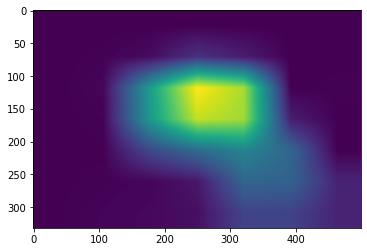

In [8]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

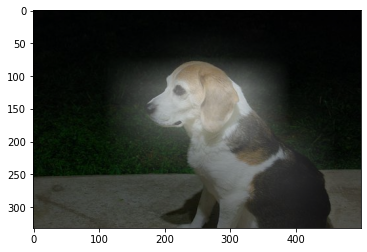

In [9]:
# CAM 이미지를 원본 이미지와 합쳐 보기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha) #  # src2에 적용할 투명도 값 (alpha와 상호 보완)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


origin_image = item['image'].astype(np.uint8)

#CAM 이미지는 흑백(1채널)이므로, RGB 3채널로 확장
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## GRAD-CAM 구하기

90


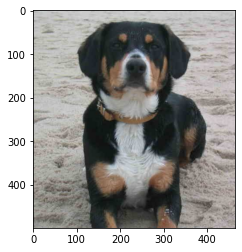

In [10]:
#GRAD-CAM 구하기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [18]:
def generate_grad_cam(model, activation_layer, item):
    """
    Grad-CAM 생성 함수

    Args:
        model: 학습된 Keras 모델
        activation_layer: 마지막 Conv layer의 이름
        item: {'image': 원본 이미지, 'label': 정답 클래스} 형태의 dict

    Returns:
        grad_cam_image: 정규화된 CAM 이미지 (numpy array, 0~1 범위)
    """

    # 1. 이미지 준비: 전처리 및 클래스 인덱스 추출
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # 2. Conv Layer 출력과 모델 출력(Logits)을 동시에 얻기 위한 모델 구성
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(activation_layer).output, model.output]
    )

    # 3. GradientTape로 미분 추적 → forward pass 수행
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(img_tensor, 0))  # (1, H, W, C), (1, num_classes)
        class_score = predictions[:, class_idx]  # 해당 클래스에 대한 score만 추출

    # 4. 해당 클래스에 대한 Conv Layer 출력의 Gradient 계산
    grads = tape.gradient(class_score, conv_outputs)  # shape: (1, H, W, C)

    # 5. 채널별 global average pooling (각 채널별 gradient를 평균 → 중요도 가중치 α_k가 됨)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # shape: (C,)

    # 6. 가중치 적용 및 채널 합산 - conv_outputs의 채널마다 α_k 곱해서 CAM 생성
    conv_outputs = conv_outputs[0].numpy()      # (H, W, C)
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    grad_cam_image = np.sum(conv_outputs, axis=-1)  # shape: (H, W)

    # 7. ReLU 적용 (음수 제거) + 정규화 (0~1)
    grad_cam_image = np.maximum(grad_cam_image, 0)
    grad_cam_image = grad_cam_image / (np.max(grad_cam_image) + 1e-8)

    # 8. 원본 이미지 크기로 resize
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

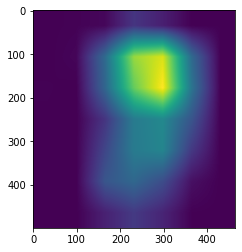

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

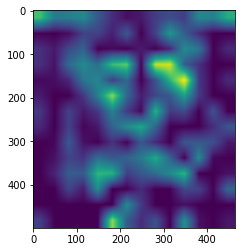

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

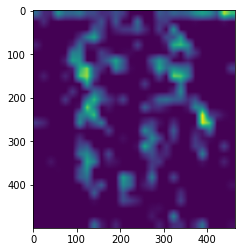

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

71


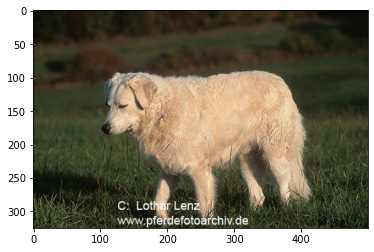

In [118]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## GRAD-CAM 바운딩 박스 구하기

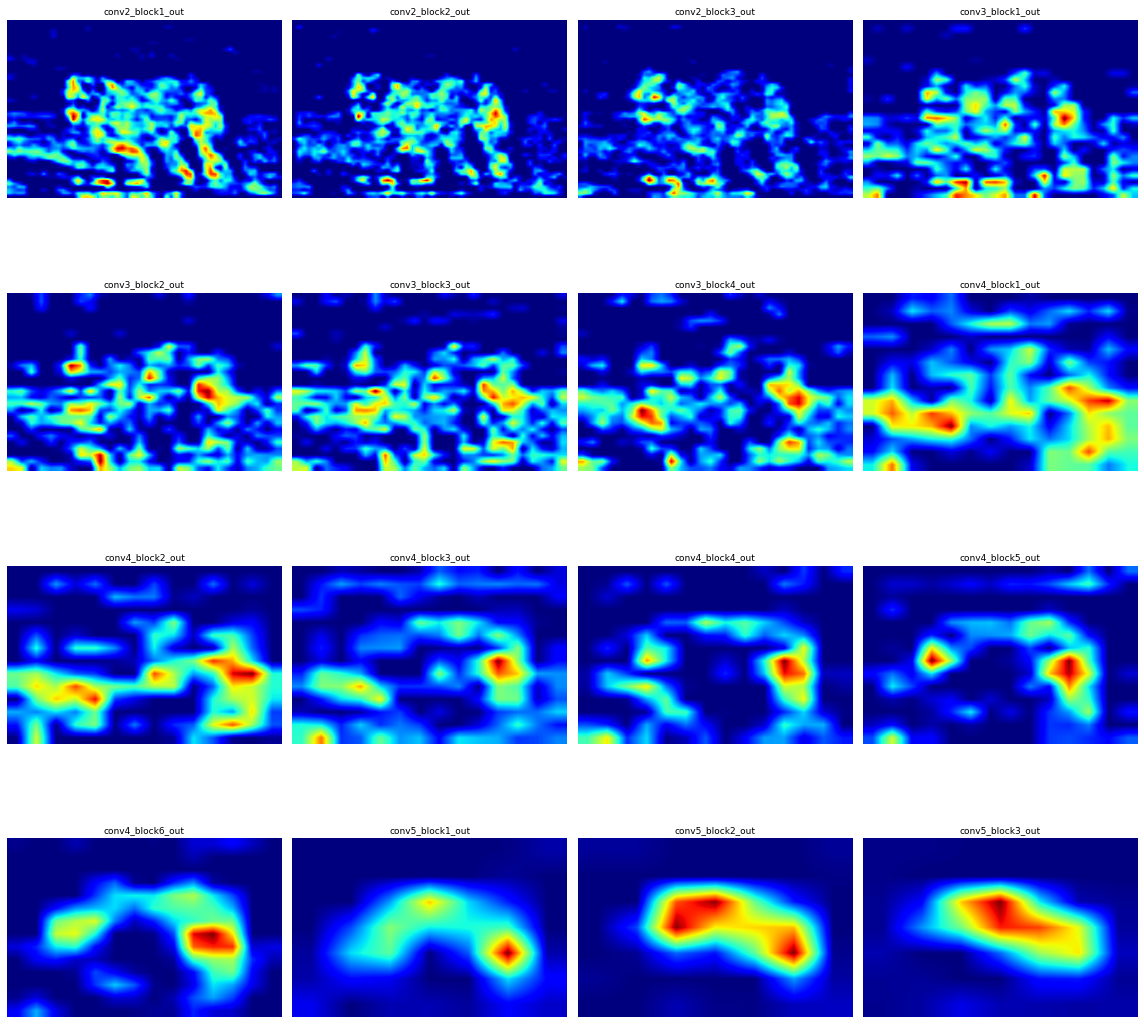

In [119]:
# GRAD-CAM 바운딩 박스 구하기

# 모델에서 Conv Block 출력을 포함하는 레이어 이름만 추출
conv_block_layers = [layer.name for layer in cam_model.layers if 'conv' in layer.name and 'out' in layer.name]

# 시각화 준비
n = len(conv_block_layers)
cols = 4
rows = (n + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))

for i, layer_name in enumerate(conv_block_layers):
    try:
        # Grad-CAM 이미지 생성
        grad_cam_image_sample = generate_grad_cam(cam_model, layer_name, item)

        # 시각화
        plt.subplot(rows, cols, i + 1)
        plt.imshow(grad_cam_image_sample, cmap='jet')
        plt.title(layer_name, fontsize=9)
        plt.axis('off')
    except Exception as e:
        print(f"Error on layer '{layer_name}': {e}")

plt.tight_layout()
plt.show()


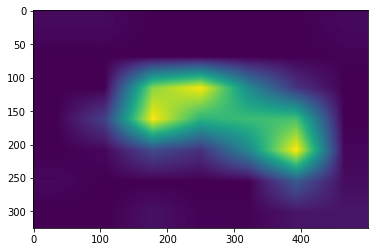

In [141]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [142]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [143]:
rect = get_bbox(grad_cam_image, score_thresh=0.4)
rect

array([[120, 184],
       [148,  63],
       [452, 133],
       [424, 254]])

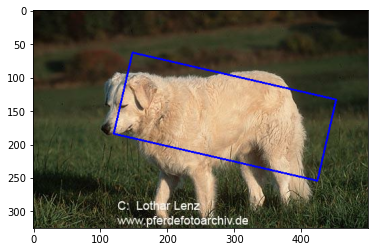

In [144]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## GRAD-CAM IOU 구하기

In [145]:
# GRAD_CAM IoU 구하기

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [146]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.19384615384615383, 0.24, 0.7815384615384615, 0.904]

In [137]:
item['objects']['bbox']

array([[0.27384615, 0.2       , 0.9969231 , 0.836     ]], dtype=float32)

In [147]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

get_iou(pred_bbox, item['objects']['bbox'][0])

0.5526457882498876

## CAM IOU 와 비교하기

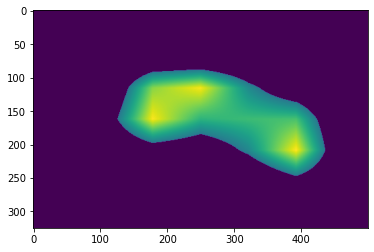

In [148]:
# CAM IOU 와 비교하기
cam_image = generate_cam(cam_model, item)
plt.imshow(grad_cam_image)
plt.show()

In [149]:
rect = get_bbox(cam_image, score_thresh=0.4)
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.46441990921793797

## 회고
- IOU 분석 결과 해당 이미지에서는 CAM 보다 GRAD CAM 의 성능이 더 좋게 나왔다.
- 이미지에 따라 CAM이 더 높게 나온 이미지도 있었다.
- GRAD CAM의 레이어 선택은 무조건 마지막 레이어가 IOU 성능이 좋은 것은 아니었다. 해당 이미지도 conv5_block2_out 로 썼을 때 가장 좋게 나왔다. 일일히 비교해볼 필요가 있어보인다. 본인은 그래프로 모두 펼쳐본 후 가능성이 높은 레이어 3-4개를 비교했다.